In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

import pickle
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pathlib, time
import PIL
import PIL.Image

from tqdm import tqdm, tqdm_notebook
# from ipywidgets import IntProgress



In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [3]:
# Check for available GPU-
gpu = tf.config.list_physical_devices('GPU')

if len(gpu) == 0:
    print(f"There are no available GPU")
else:
    print(f"Available GPU: {gpu}")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# os.getcwd()
os.listdir("/content/drive/MyDrive/")

['Getting started.pdf',
 'Colab Notebooks',
 'VGG18_Iterative_Pruning_95.43863490652879_Clustered_&_Fine_Tuned.h5',
 'Registration International Researchers.gdoc',
 'Cover_Letter-Data_Scientist.gdoc',
 'grokking-deep-reinforcement-learning_pack.zip',
 'openmoji-72x72-color.zip',
 'Resume-Data_Analyst.gdoc',
 'Resume.gdoc',
 'VGG18_summed_gradients.h5',
 'VGG18-pruned_not_trained_91.46.h5',
 'Resume-AI_ML_Engineer.gdoc',
 'Linnaeus_PhD_Presentation.gslides',
 'ResNet18_best_trained_loss.pth',
 'ResNet50__finetuned_best_trained_loss.pth',
 'Viridios_AI_Test -Task_1.ipynb',
 'Viridios_AI_Test_Task_2.ipynb',
 'DeepFashion_filenames_inceptionnetv3.pickle',
 'DeepFashion_features_inceptionnetv3.pickle',
 'img.zip',
 'DeepFashion_InceptionNetV3_Autoencoder_trained_weights.h5',
 'DeepFashion_encoded_features_inceptionnetv3.pickle']

In [ ]:
# Copy zipped image file from Google Drive to Colab directory-
# !unzip "/content/drive/MyDrive/img.zip" -d "/content/"

In [9]:
# Read pickled Python3 list containing 2048-d extracted feature representation per image-
features_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_features_inceptionnetv3.pickle", "rb"))

In [10]:
# Convert from Python3 list to numpy array-
features_list_np = np.asarray(features_list)

features_list_np.shape

(289229, 2048)

In [11]:
del features_list

In [12]:
# Read pickled Python3 list containing abolute path and filenames-
filenames_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_filenames_inceptionnetv3.pickle", "rb"))

In [13]:
features_list_np.shape[0], len(filenames_list)

(289229, 289229)

In [14]:
# Note that the absolute path contains Google colab path-
filenames_list[1]

'/content/img/1981_Graphic_Ringer_Tee/img_00000002.jpg'

In [40]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            InputLayer(input_shape = (2048, )),
            Dense(
                units = 1500, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 1000, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 500, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 250, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])

        self.decoder = Sequential([
            Dense(
                units = 500, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 1000, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 1500, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 2048, activation = 'sigmoid',
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def model(self):
        x = Input(shape=(2048,))
        return Model(inputs = [x], outputs = self.call(x))
    

           

In [15]:
"""
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            InputLayer(input_shape = (2048, )),
            Dense(
                units = 1024, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 512, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 256, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
        self.decoder = Sequential([
            Dense(
                units = 512, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 1024, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 2048, activation = 'sigmoid',
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def model(self):
        x = Input(shape=(2048,))
        return Model(inputs = [x], outputs = self.call(x))

"""

In [41]:
# Initialize and build defined autoencoder-
model = Autoencoder()
model.build(input_shape = (None, 2048))

In [42]:
model.model().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 250)               5200250   
_________________________________________________________________
sequential_5 (Sequential)    (None, 2048)              5202048   
Total params: 10,402,298
Trainable params: 10,402,298
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.summary()

Model: "autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 250)               5200250   
_________________________________________________________________
sequential_5 (Sequential)    (None, 2048)              5202048   
Total params: 10,402,298
Trainable params: 10,402,298
Non-trainable params: 0
_________________________________________________________________


In [44]:
tot_params = 0

for layer in model.trainable_weights:
    loc_param = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_param
    print(f"layer: {layer.shape} has {loc_param} wts")
    

layer: (2048, 1500) has 3072000 wts
layer: (1500,) has 1500 wts
layer: (1500, 1000) has 1500000 wts
layer: (1000,) has 1000 wts
layer: (1000, 500) has 500000 wts
layer: (500,) has 500 wts
layer: (500, 250) has 125000 wts
layer: (250,) has 250 wts
layer: (250, 500) has 125000 wts
layer: (500,) has 500 wts
layer: (500, 1000) has 500000 wts
layer: (1000,) has 1000 wts
layer: (1000, 1500) has 1500000 wts
layer: (1500,) has 1500 wts
layer: (1500, 2048) has 3071998 wts
layer: (2048,) has 2048 wts


In [45]:
print(f"Total number of trainable parameters in Autoencoder: {tot_params}")

Total number of trainable parameters in Autoencoder: 10402296


In [46]:
# Sanity check-
x = features_list_np[:5, :]
x.shape

(5, 2048)

In [47]:
x_encoded = model.encoder(x)
x_encoded.shape

TensorShape([5, 250])

In [48]:
x_reconstructed = model.decoder(x_encoded)
x_reconstructed.shape

TensorShape([5, 2048])

In [49]:
# Compile model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.MeanSquaredError()
    )

In [50]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss', min_delta = 0.001, patience = 3, verbose = 0,
    mode = 'auto', baseline = None, restore_best_weights = False
)

In [51]:
# Train autoencoder-
history = model.fit(
    x = features_list_np, y = features_list_np,
    epochs = 10, batch_size = 32,
    callbacks = [early_stopping]
    )

Epoch 1/10
9039/9039 [==============================] - 38s 4ms/step - loss: 5.9626e-04
Epoch 2/10
9039/9039 [==============================] - 38s 4ms/step - loss: 4.8828e-04
Epoch 3/10
9039/9039 [==============================] - 38s 4ms/step - loss: 4.8828e-04
Epoch 4/10
9039/9039 [==============================] - 38s 4ms/step - loss: 4.8828e-04


In [64]:
history.history.keys()

dict_keys(['loss'])

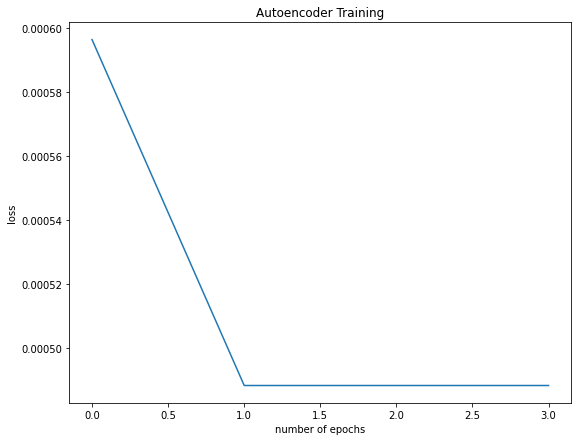

In [52]:
plt.figure(figsize = (9, 7))

plt.plot(history.history['loss'])
plt.title("Autoencoder Training")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

In [74]:
# Save trained weights of Autoencoder model-
model.save_weights("DeepFashion_InceptionNetV3_Autoencoder2_trained_weights.h5", overwrite = True)

In [68]:
x.shape, model.encoder(x).shape

((5, 2048), TensorShape([5, 128]))

In [69]:
range(features_list_np.shape[0])

range(0, 289229)

In [71]:
i = 10
features_list_np[i, :].shape

(2048,)

In [79]:
# model.encoder(features_list_np[0, :])
i = 12
features_list_np[i].reshape(1, 2048).shape

(1, 2048)

Define a Python3 list variable that will store all of the encoded extracted features by appending them.

In [80]:
features_encoded = []

for i in tqdm.notebook.tqdm(range(features_list_np.shape[0])):
# for i in tqdm_notebook(range(features_list_np.shape[0])):
    features_encoded.append(model.encoder(features_list_np[i].reshape(1, 2048)))
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [84]:
# Sanity check-
features_list_np.shape[0], len(features_encoded)

(289229, 289229)

In [85]:
# Write these encoded extracted features to a pickle file so that we can use
# them in the future without having to recalculate them-
pickle.dump(features_encoded, open("DeepFashion_encoded_features_inceptionnetv3.pickle", "wb"))

In [86]:
# Copy extracted features to Google Drive-
!cp DeepFashion_encoded_features_inceptionnetv3.pickle /content/drive/MyDrive/